McGill University EXMD 521 Final Project Report

# Intra-tumoral heterogeneity and cell-cell communication in acute myeloid leukemia by single-cell RNA sequencing

by Amirali Vahedi - December 21st, 2023

The following script represents an example analysis workflow for a representative patient. All of the below steps were performed for every cases in our cohort of 10 patients. For details regarding the results, refer to the research letter.

1. Import the necessary packages for the analysis. These include Numpy and Pandas for array-like and tabular data processing, Scanpy and Anndata for scRNAseq analysis, and LIANA+ for cell-cell communication inference.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import warnings
import liana as li
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

2. Set a few global parameters for visualization.

In [2]:
sc.set_figure_params(scanpy=True, dpi=150)
warnings.filterwarnings('ignore')

3. Read the raw cell-gene data matrix into an Anndata object.

In [3]:
data = sc.read_10x_h5('example_patient_raw_matrix.h5')
data.var_names_make_unique()

4. Perform preprocessing and quality control. Visualizing QC parameters before and after QC ensures correct filtering.

In [4]:
sc.pp.filter_genes(data, min_cells=3)
sc.pp.filter_cells(data, min_genes=200)

data.var['mt'] = data.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False,
                           inplace=True)

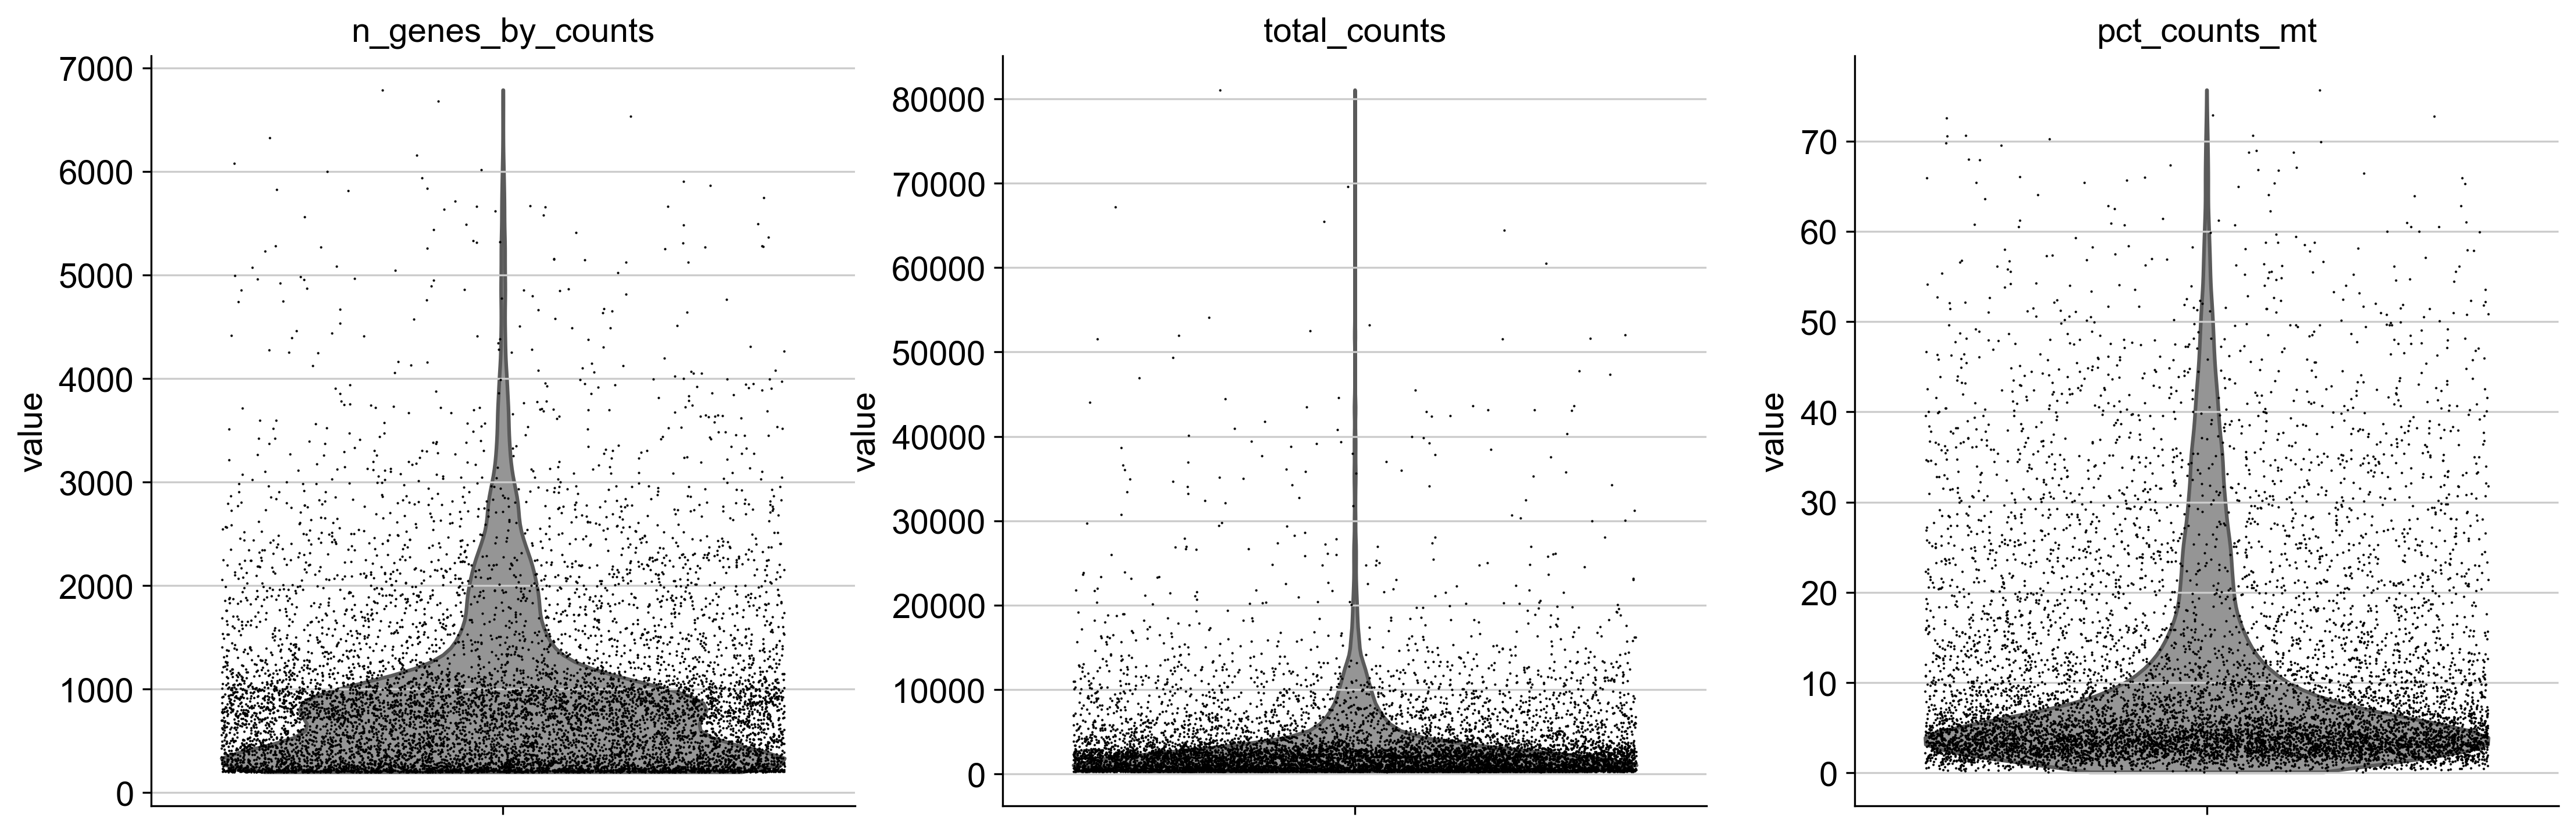

In [5]:
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, palette='Greys')

In [6]:
data = data[data.obs.n_genes_by_counts < 4000, :]
data = data[data.obs.total_counts < 20000, :]
data = data[data.obs.pct_counts_mt <= 10, :]

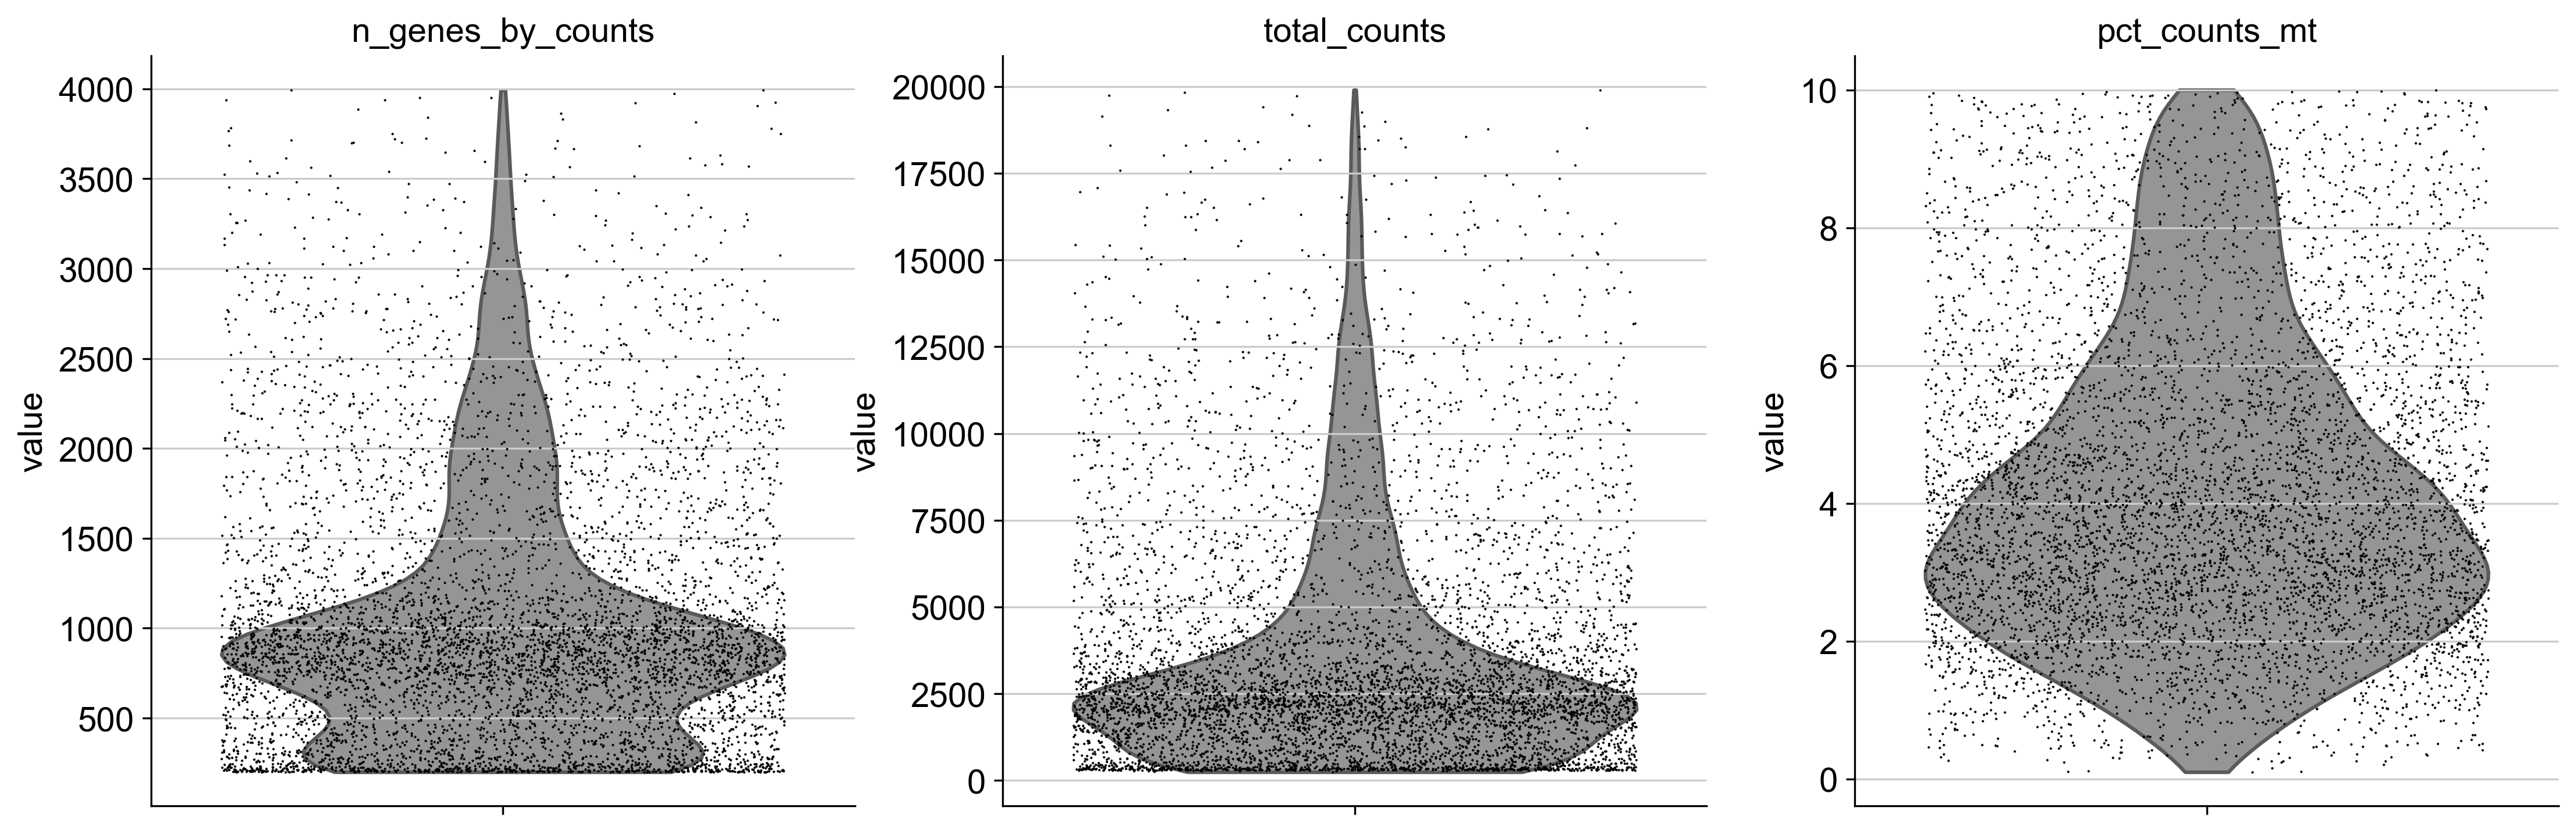

In [7]:
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, palette='Greys')

5. Perform data normalization, logarithmization, and rescaling.

In [8]:
sc.pp.normalize_total(data, target_sum=10000)
sc.pp.log1p(data)
sc.pp.scale(data, max_value=10)

6. Compute a neighborhood graph of cells and perform dimensionality reduction with UMAP.

         Falling back to preprocessing with `sc.pp.pca` and default params.


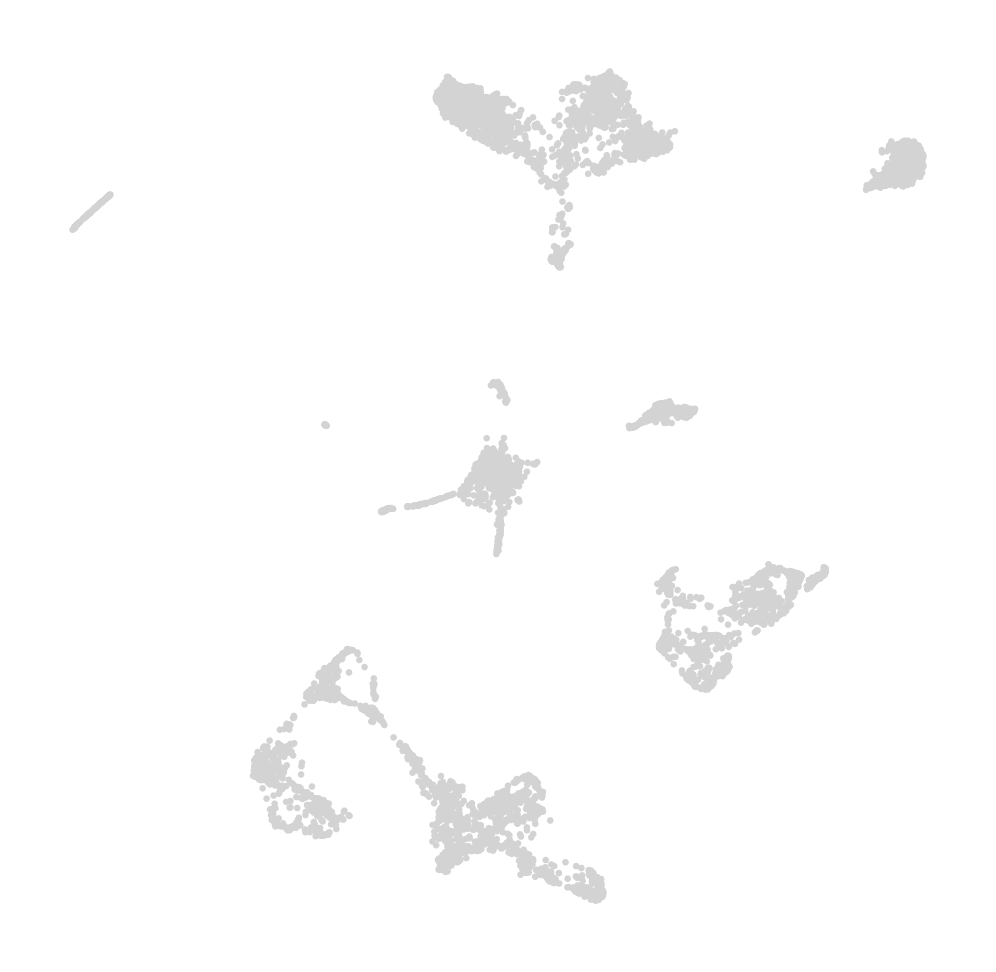

In [9]:
sc.pp.neighbors(data, n_neighbors=20, n_pcs=30)
sc.tl.umap(data, min_dist=0.1)
sc.pl.umap(data, s=10, frameon=False)

7. Perform cell clustering by Leiden with a relatively high resolution.

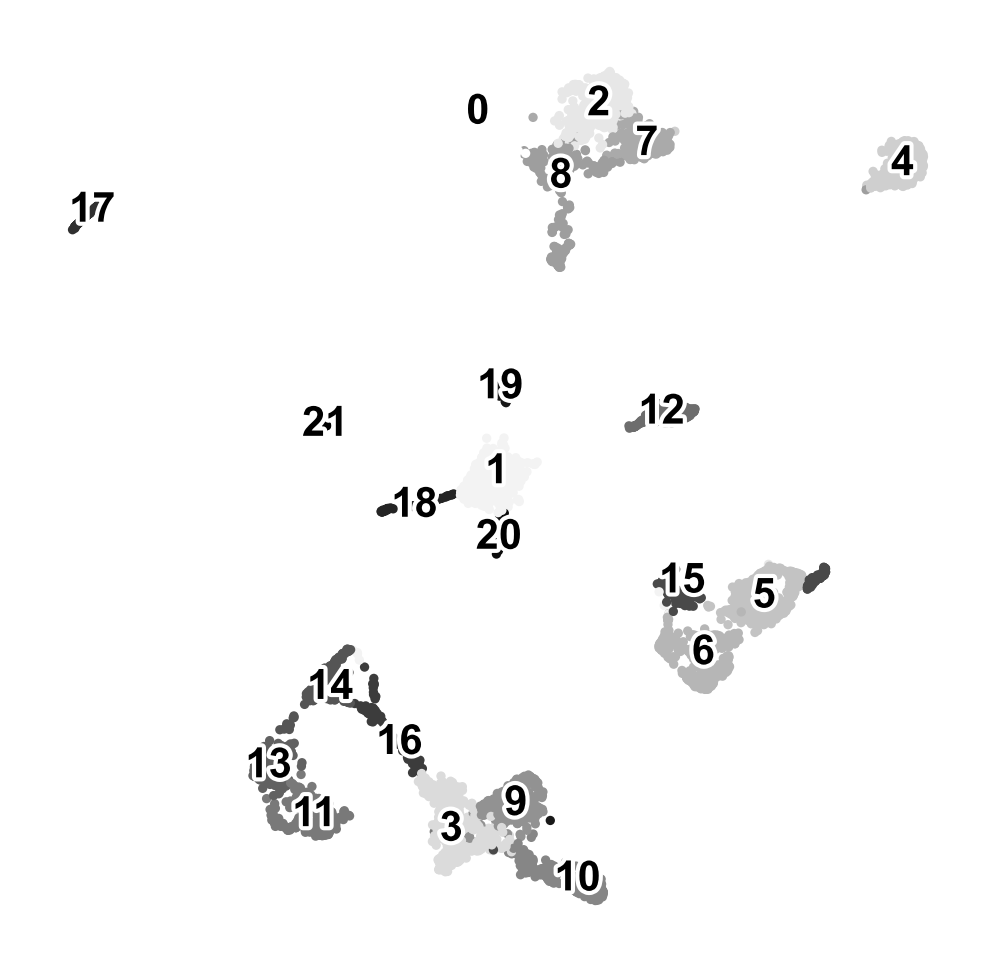

In [10]:
sc.tl.leiden(data, resolution=1.0, random_state=50)
sc.pl.umap(data, color=['leiden'], legend_loc='on data', palette='binary',
           legend_fontsize=10, legend_fontoutline=2, s=20, frameon=False,
           title='')

8. Merge and reorder clusters based on the UMAP visualitation and the resulting dotplot further analyzed for cell-type annotation. This step is an iterative process which ensures the clusters achieved are biologically sound. Although manual and semi-subjective, this approach guarantees true cell separation based on biology.

In [11]:
data.obs['leiden'][data.obs['leiden'].isin(['3', '16', '9'])] = '10'
data.obs['leiden'][data.obs['leiden'].isin(['2', '7', '0'])] = '8'
data.obs['leiden'][data.obs['leiden'].isin(['19', '18', '20'])] = '1'
data.obs['leiden'][data.obs['leiden'].isin(['15', '5'])] = '6'
data.obs['leiden'][data.obs['leiden'].isin(['11', '14'])] = '13'

data.obs['leiden'] = data.obs['leiden'].astype('str').astype('category')
cluster_mapping = dict(zip(np.unique(data.obs['leiden']), np.arange(len(np.unique(data.obs['leiden'])))))
data.obs['leiden'] = data.obs['leiden'].replace(cluster_mapping)
data.obs['leiden'] = data.obs['leiden'].astype('str')
data.obs['leiden'] = data.obs['leiden'].astype('category')

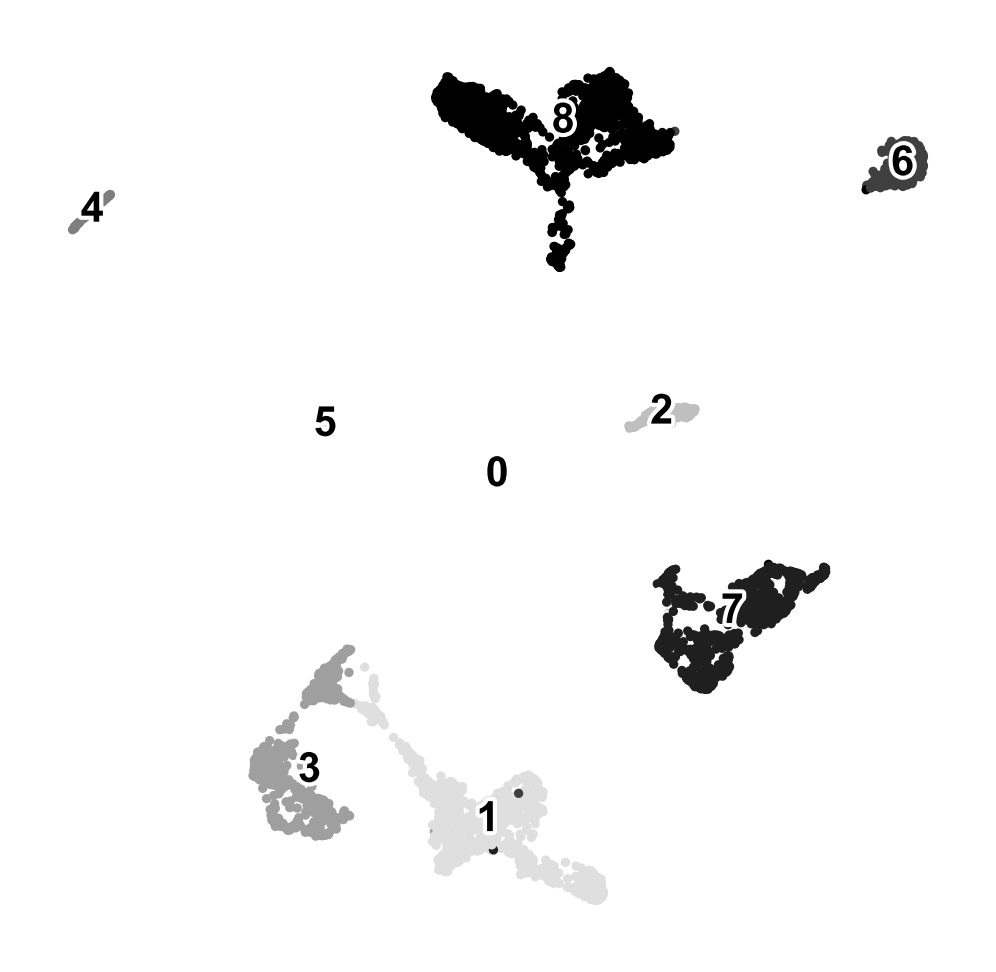

In [12]:
sc.pl.umap(data, color=['leiden'], legend_loc='on data', palette='binary',
           legend_fontsize=10, legend_fontoutline=2, s=20, frameon=False,
           title='')

9. Annotate cell clusters based on biologically known marker genes.

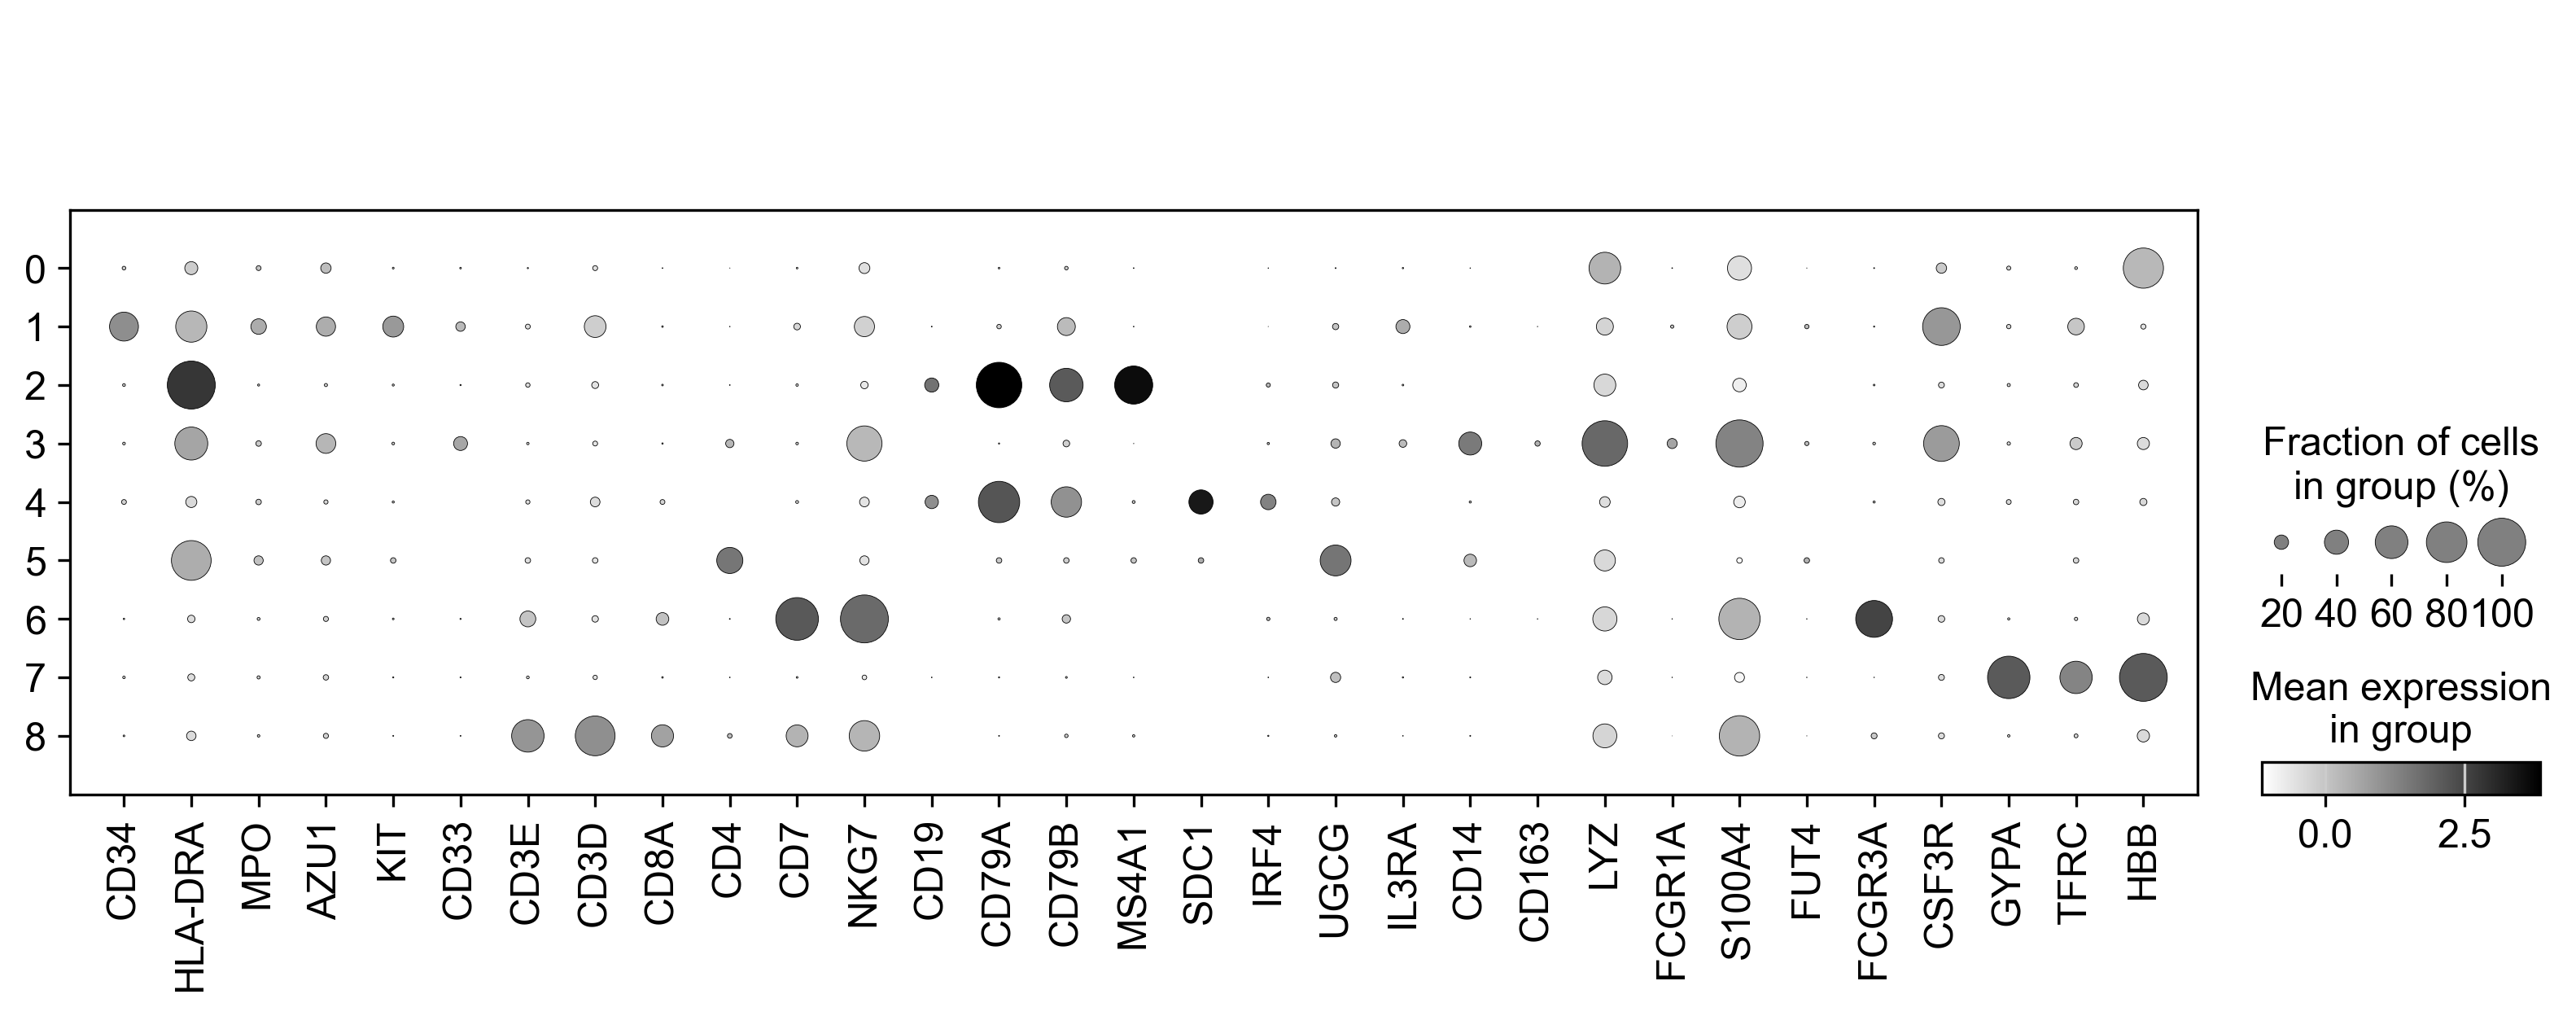

In [13]:
marker_genes = ['CD34', 'HLA-DRA', 'MPO', 'AZU1', 'KIT', 'CD33',
                'CD3E', 'CD3D', 'CD8A', 'CD4',
                'CD7', 'NKG7', 
                'CD19', 'CD79A', 'CD79B', 'MS4A1',
                'SDC1', 'IRF4', 'UGCG', 'IL3RA',
                'CD14', 'CD163', 'LYZ', 'FCGR1A', 'S100A4', 'FUT4', 'FCGR3A', 'CSF3R',
                'GYPA', 'TFRC', 'HBB']
sc.pl.dotplot(data, marker_genes, groupby='leiden', color_map='binary')

In [14]:
pops = ['',
        'Leukemic cells',
        'B-cells',
        'Monocytes',
        'Plasma cells',
        'pDCs',
        'NK-cells',
        'Erythroid cells',
        'T-cells']
data.rename_categories('leiden', pops)

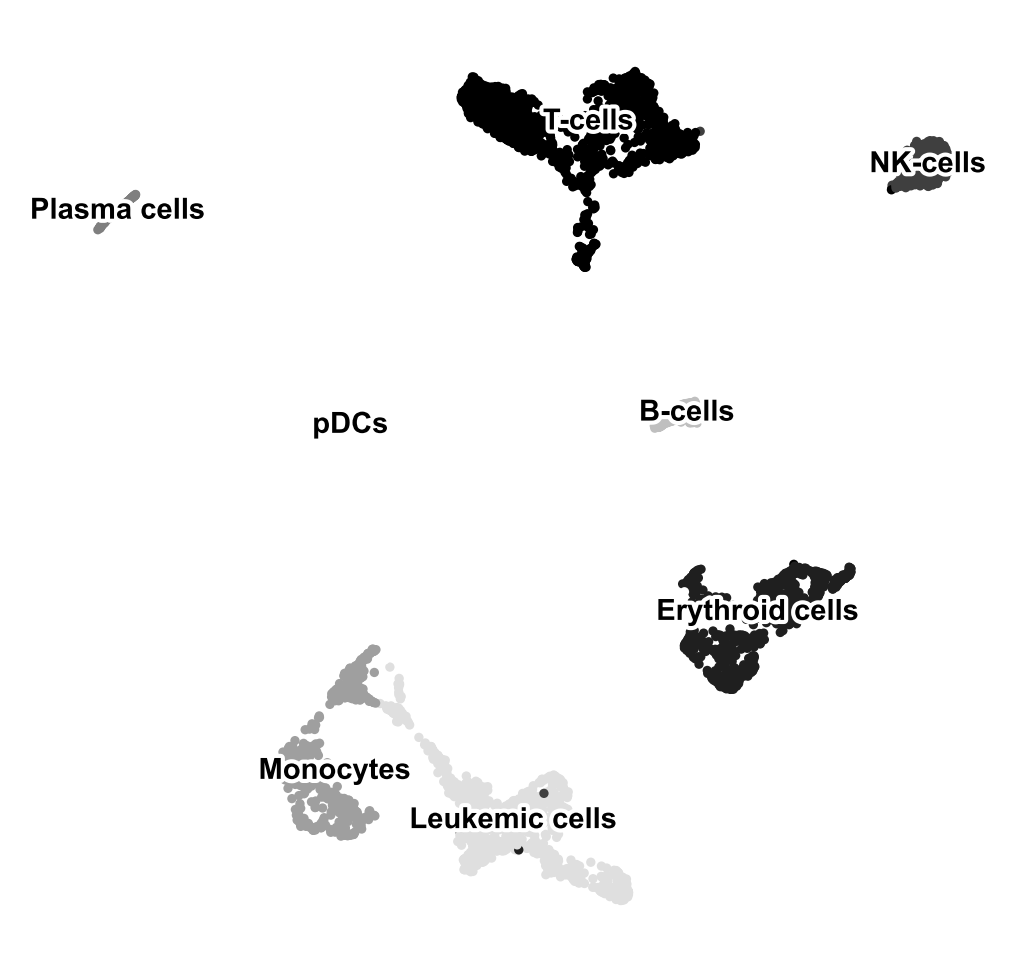

In [15]:
sc.pl.umap(data, color=['leiden'], palette='binary', legend_loc='on data',
           legend_fontsize=7, legend_fontoutline=2, s=20, frameon=False,
           title='')

10. Extract the leukemic cell population for downstream analysis.

In [16]:
data_l = data[data.obs.leiden == 'Leukemic cells', :]

11. Compute a PAGA-initiated neighborhood graph of cells and perform dimensionality reduction with UMAP and clustering with Leiden.

In [17]:
sc.pp.neighbors(data_l, n_neighbors=20, n_pcs=30)
sc.tl.umap(data_l, min_dist=0.1)

In [18]:
sc.tl.leiden(data_l, resolution=0.3, random_state=50)

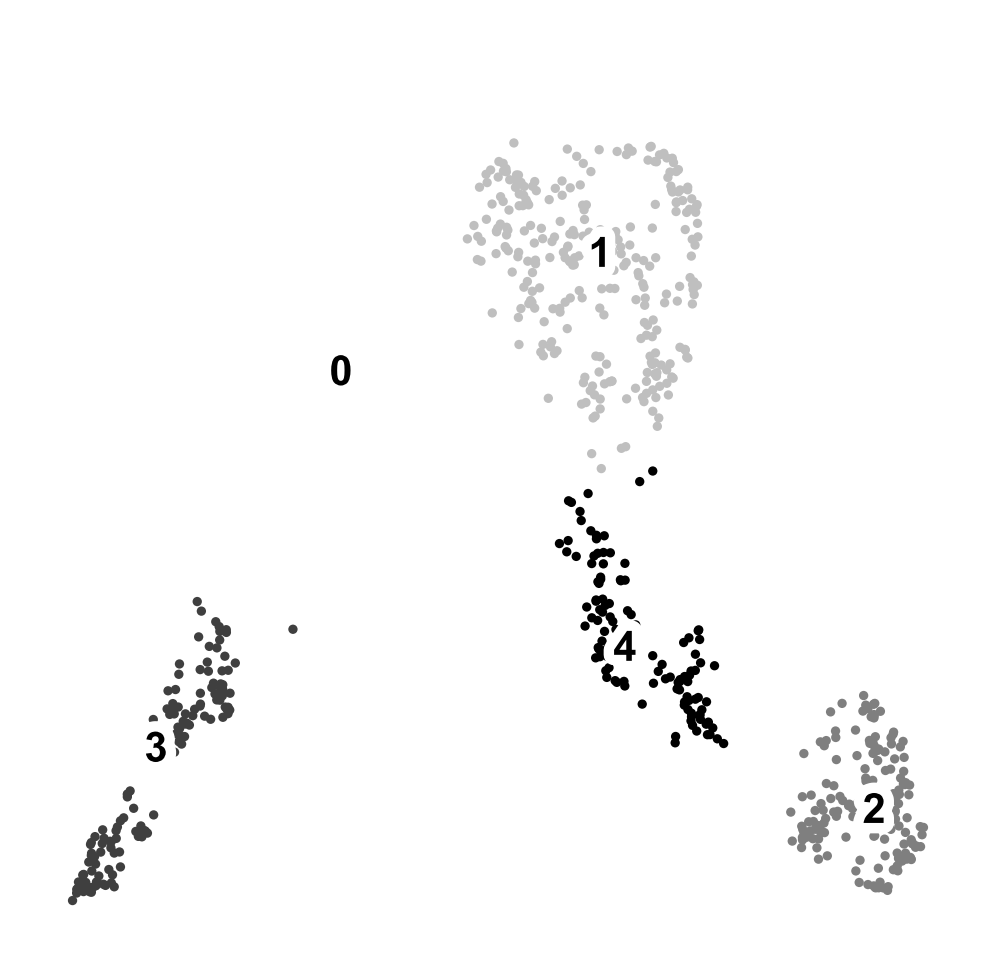

In [19]:
sc.pl.umap(data_l, color=['leiden'], legend_loc='on data', palette='binary',
           legend_fontsize=10, legend_fontoutline=5, s=20, frameon=False,
           title='', cmap='cividis', vmin=0, vmax=0.5)

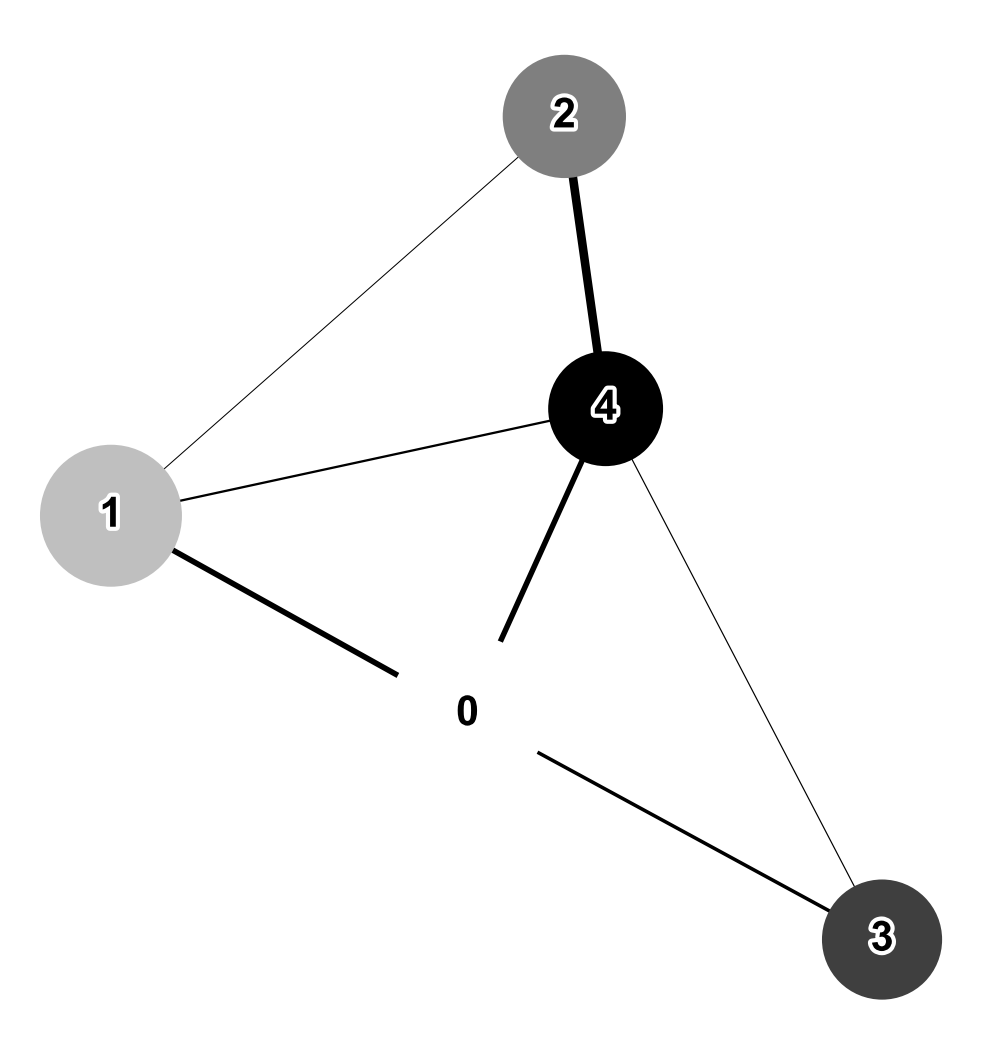

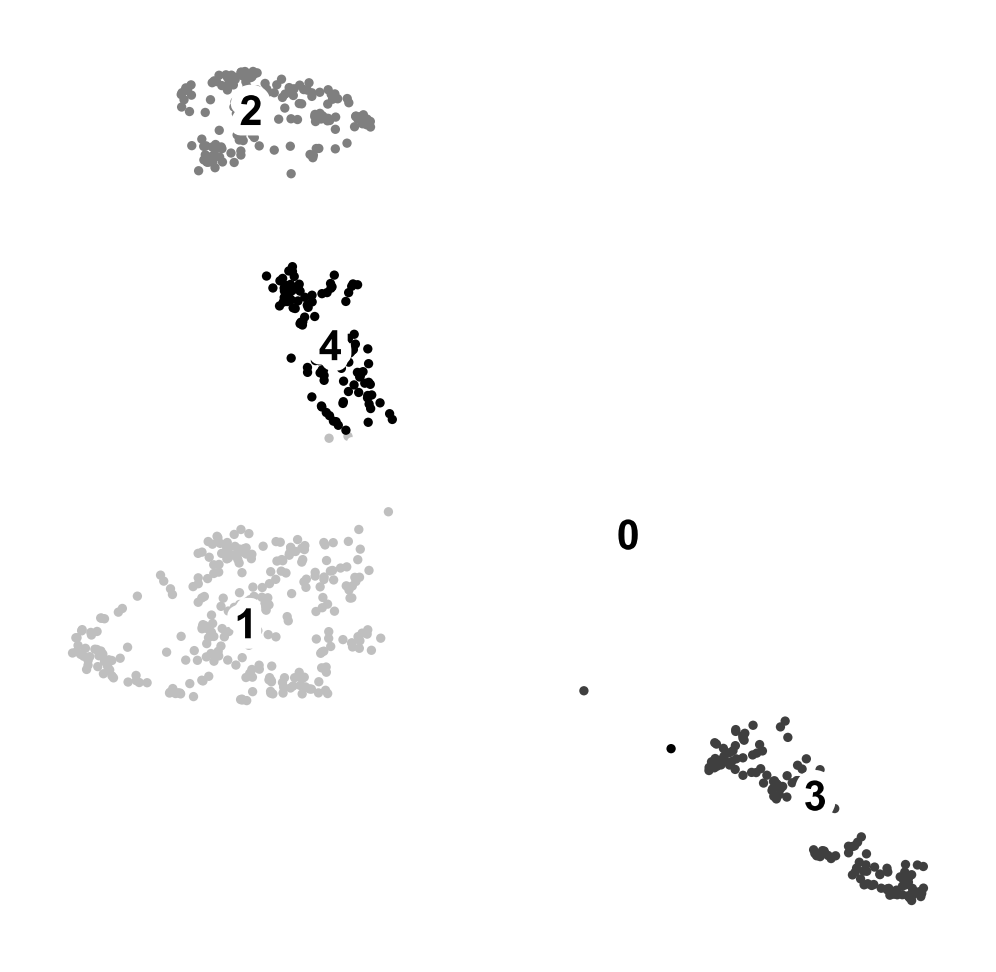

In [20]:
sc.tl.paga(data_l, groups='leiden')
sc.pl.paga(data_l,
           color=['leiden'],
           fontsize=10,
           fontoutline=2,
           frameon=False,
           cmap='binary',
           node_size_scale=5)
sc.tl.umap(data_l, min_dist=0.1, init_pos='paga')
sc.pl.umap(data_l, color=['leiden'], legend_loc='on data', palette='binary',
           legend_fontsize=10, legend_fontoutline=5, s=20, frameon=False,
           title='', cmap='cividis', vmin=0, vmax=0.5)

12. Using a published panel of atlas-level cell signatures including cell states, transcription factors and markers, manually annotate leukemic cell subsets.

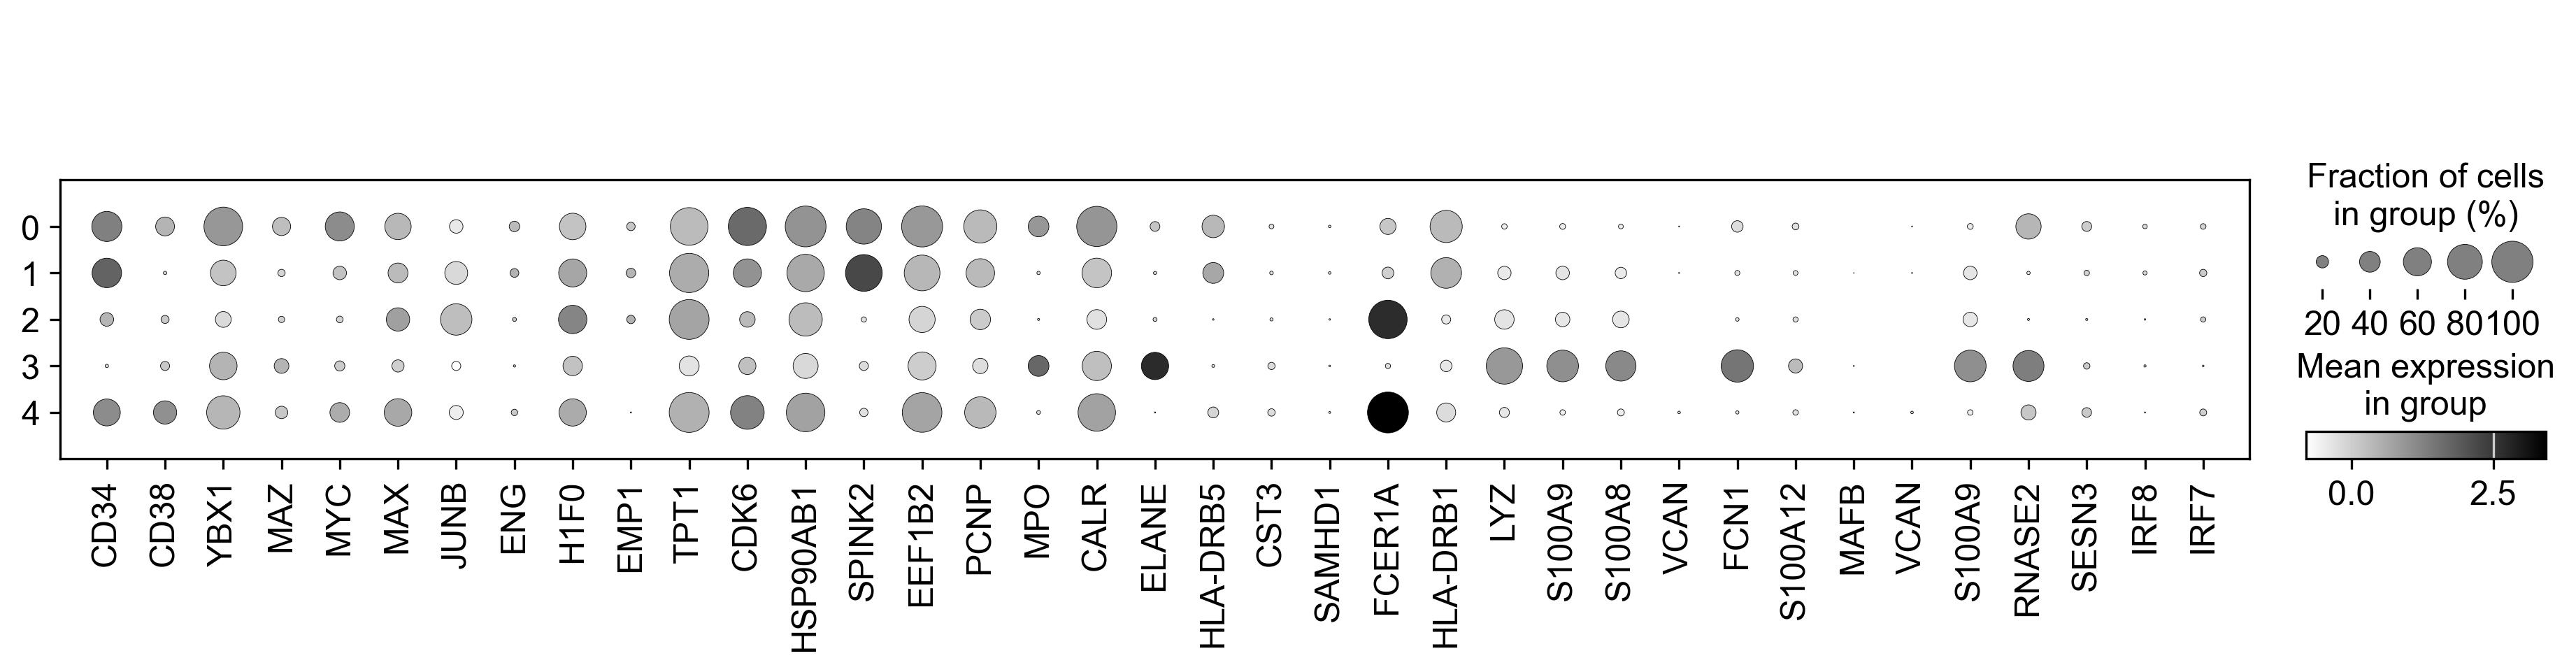

In [21]:
int_genes_l = ['CD34', 'CD38', 'YBX1', 'MAZ', 'MYC', 'MAX', 'JUNB', 'ENG',
               'H1F0', 'EMP1', 'TPT1',
               'CDK6', 'HSP90AB1', 'SPINK2', 'EEF1B2', 'PCNP',
               'MPO', 'CALR', 'ELANE',
               'HLA-DRB5', 'CST3', 'SAMHD1', 'FCER1A', 'HLA-DRB1',
               'LYZ', 'S100A9', 'S100A8', 'VCAN',
               'FCN1', 'S100A12', 'MAFB', 'VCAN', 'S100A9',
               'RNASE2', 'SESN3', 'IRF8', 'IRF7']
sc.pl.dotplot(data_l, int_genes_l, groupby='leiden', color_map='binary')

In [22]:
pops_l = ['Progenitor-like',
          'HSC-like',
          'Erythroid-like',
          'Neutrophil-like',
          'Dendritic-like']
data_l.rename_categories('leiden', pops_l)

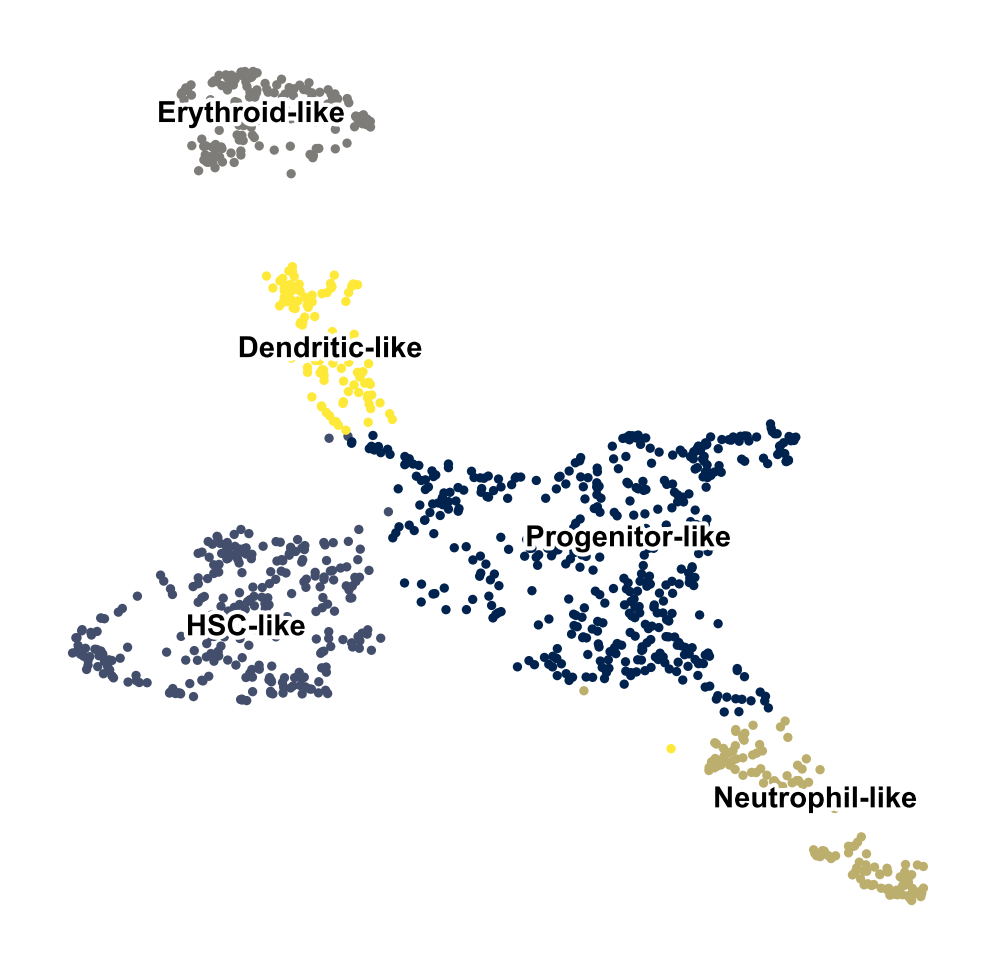

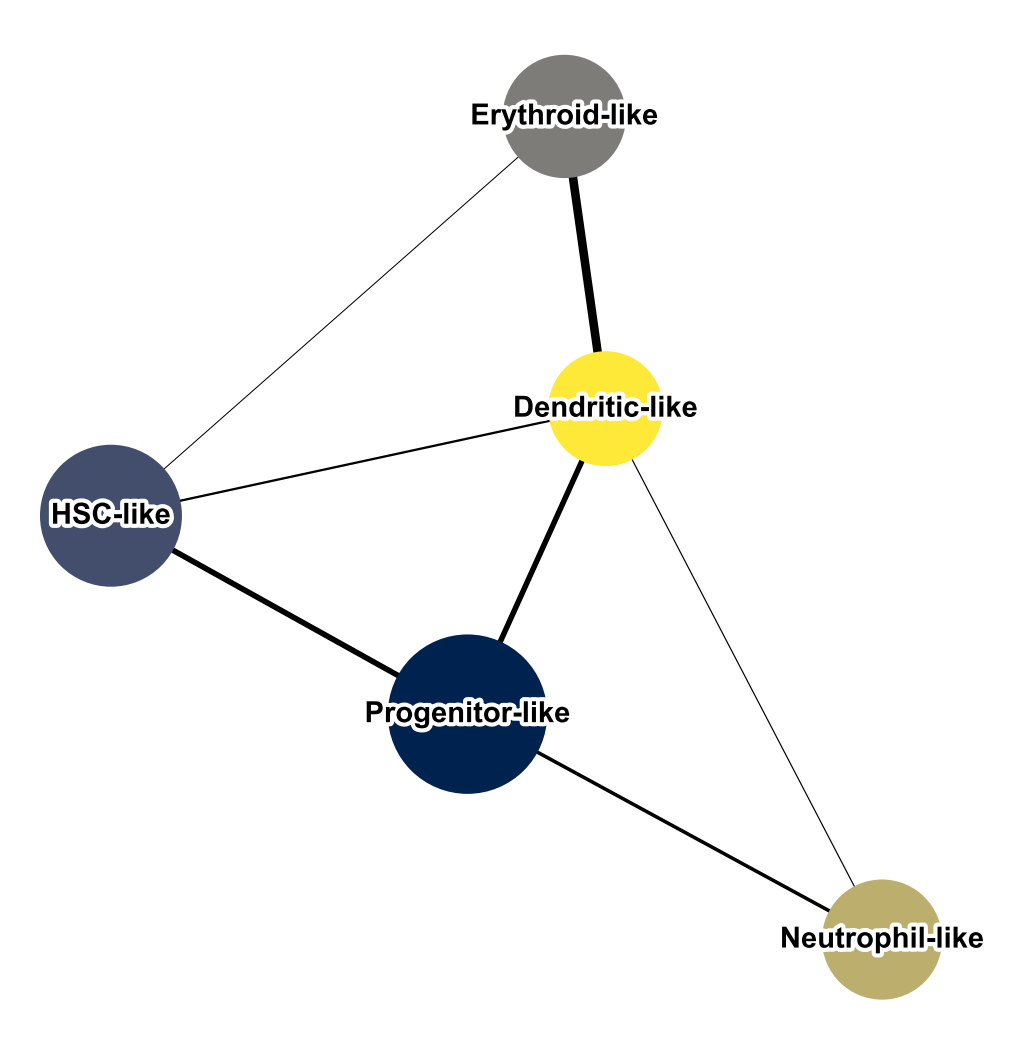

In [23]:
sc.pl.umap(data_l, color=['leiden'], legend_loc='on data', palette='cividis',
           legend_fontsize=7, legend_fontoutline=2, s=20, frameon=False,
           title='', cmap='cividis', vmin=0, vmax=0.5)
sc.pl.paga(data_l,
           color=['leiden'],
           fontsize=7,
           fontoutline=2,
           frameon=False,
           cmap='cividis',
           node_size_scale=5)

13. Perform cell-cell communication inference with CellPhoneDB package and save the resulting csv file for further analysis.

In [24]:
cellphonedb(data_l, groupby='leiden', expr_prop=0.1, verbose=True,
            key_added='cpdb_res', use_raw=False)

Using `.X`!
Converting to sparse csr matrix!
115 features of mat are empty, they will be removed.
['RP11-442N24__B.1', 'RP11-59D5__B.2', 'XXyac-YX65C7_A.2', 'RP11-453F18__B.1', 'Y_RNA', 'Y_RNA-1', 'RP4-633O19__A.1'] contain `_`. Consider replacing those!
Using resource `consensus`.
0.34 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 1157 samples and 18466 features


100%|██████████| 1000/1000 [00:17<00:00, 57.82it/s]


In [25]:
data_l.uns['cpdb_res'].to_csv('LR_results.csv')

14. Visualize the top 10 significant ligand-receptor interactions with a dotplot.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


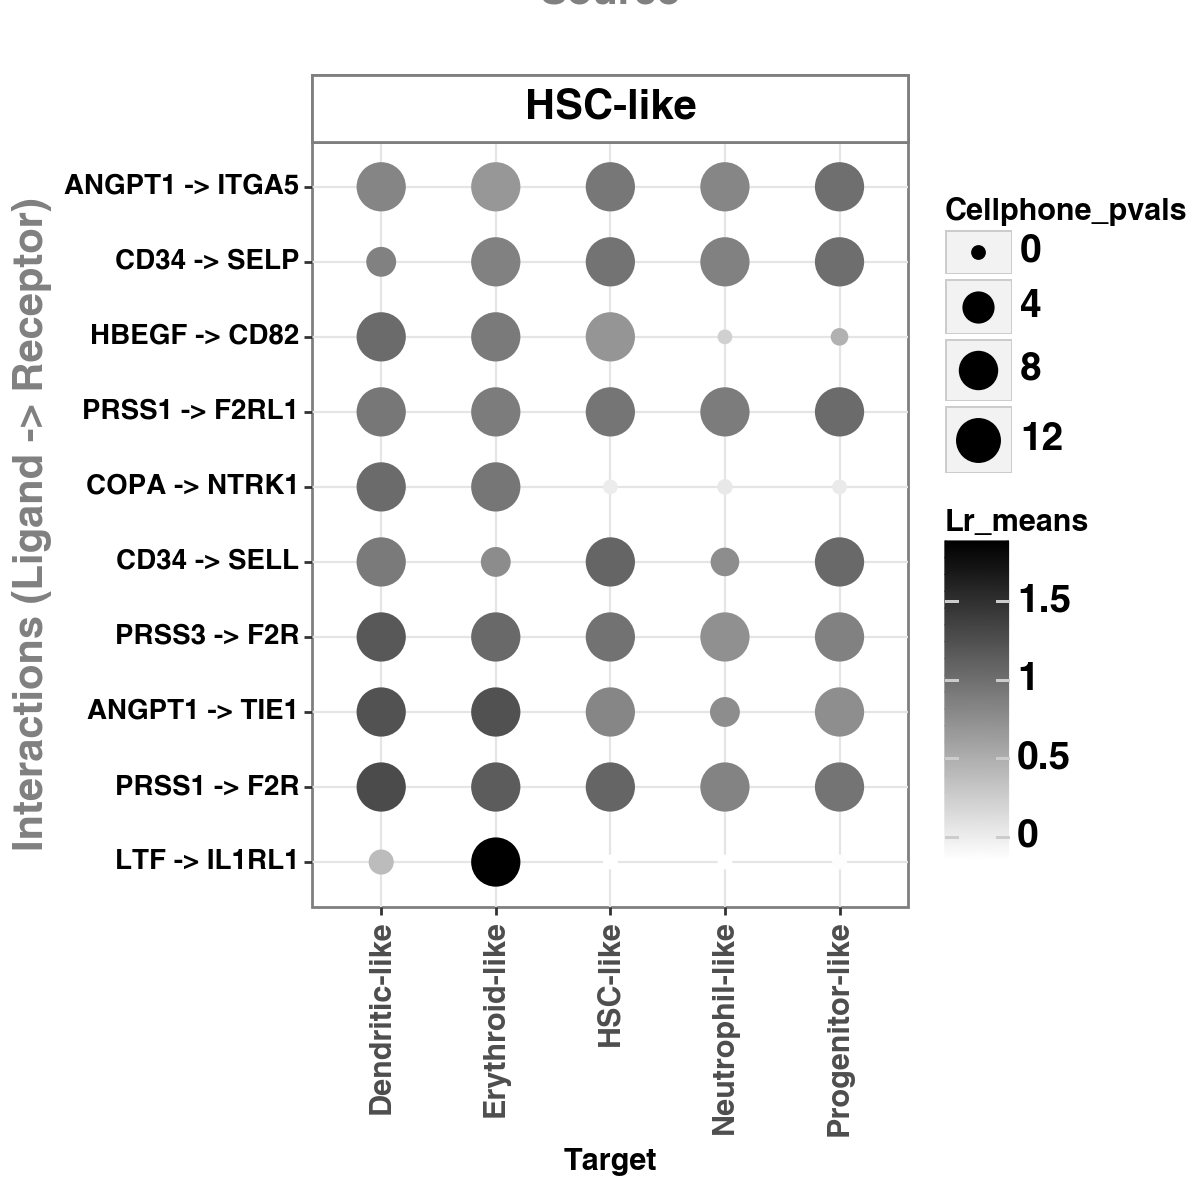

<Figure Size: (600 x 600)>

In [26]:
li.pl.dotplot(adata = data_l,
              colour='lr_means',
              cmap='binary',
              size='cellphone_pvals',
              inverse_size=True,
              source_labels=['HSC-like'],
              target_labels=['Progenitor-like', 'HSC-like', 'Erythroid-like', 'Neutrophil-like', 'Dendritic-like'],
              figure_size=(6, 6),
              filterby='cellphone_pvals',
              filter_lambda=lambda x: x == 0,
              uns_key='cpdb_res',
              orderby='lr_means',
              orderby_ascending=False,
              top_n=10)